# Parameter sweeps - sampling delay, number/distribution of partners, and risk of transmission (per-act transmission probability)

Parameter sweeps for clustering statistics.

## Parameters for sweeps

Here we define the overall parameters that will be used for running the analysis. The parameters include a LABEL to name the experiments and output data, the path to actually save the output data, sampling rates, cutoffs, as well as any other simulation parameter.

In [1]:
# Experiment
LABEL          = 'sweeps-lambda-delay-partners-samplesize1000b-C-reduntantVM'
RESULTS_PATH   = '../results'
REPS = 5  # Repeat simulations with different random number seeds for every set of parameters
RUN_SIMS = False
SHOW_RESULTS = True

# Clustering stats
#SAMPLING_RATES = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 ]
SAMPLING_RATES = [ 0.1, 0.2, 0.3, 0.6, 0.7, 0.8 ]
CUTOFFS        = [k*365 for k in [2, 5]]


# Branching process simulation
sample_size_sweep      = [ 1_000 ]

partner_number_sweep   = [ 0.20, 0.225, 0.25, 0.275,
                           0.30, 0.325, 0.35, 0.375,
                           0.40, 0.425, 0.45, 0.475,
                           0.50, 0.525, 0.55, 0.575,
                           0.60, 0.625, 0.65, 0.675
                          ] # [ 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.60, 0.70 ]

acts_per_day_sweep     = [ 0.10   ]
lambda_parameter_sweep = [ 0.001, 0.00125, 0.0015, 0.00175,
                           0.002, 0.00225, 0.0025, 0.00275,
                           0.003, 0.00325, 0.0035, 0.00375,
                           0.004, 0.00425, 0.0045, 0.00475,
                           0.005
                          ] # [ 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005 ]
removal_rate_sweep     = [ 0.0005 ]

sampling_delay_sweep   = [ 90, 180, 270, 360 ]


# Simulation defaults
SAMPLE_SIZE      = 250
SIM_TIME         = 365*20
RAND_SEED_OFFSET = 0

# Network defaults
MEAN_PARTNER = 0.35

# Transmission defaults          
ACTS_PER_DAY = 0.1
LAMBDA       = 0.001
REMOVAL_RATE = 0.0005

# Sampling defaults
SAMPLING_DELAY = 180

## Initialization

Imports and environment configuration. We also expand the definition of the parameters for the sweeps into a full collection of parameter sets.

In [2]:
import os
import itertools
import time
import warnings
import traceback
import multiprocessing

import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

from find_clusters import run_analysis

... joining trees without copying them


In [3]:
# Create output directory and file name prefix
results_dir = os.path.join( os.path.abspath(RESULTS_PATH), LABEL )
if os.path.exists( results_dir ):
    print( '... the directory ', results_dir )
    print( '    already exists. Simulation results may overwrite files in' )
    print( '    this directory.' )
    if input( '    Do you want to continue? [y/N] ' ) != 'y':
        raise Exception('stopping execution')
else:
    os.makedirs( results_dir )

output_prefix = results_dir + '/' + LABEL

In [4]:
# Generate list of parameter sets
parameter_combinations = list( itertools.product( partner_number_sweep,
                                                  lambda_parameter_sweep,
                                                  acts_per_day_sweep,
                                                  removal_rate_sweep,
                                                  sampling_delay_sweep,
                                                  sample_size_sweep
                                                 )
                              )

print( '... there are ', len(parameter_combinations), ' sets of parameters' )           

... there are  1360  sets of parameters


## Run branching process model

We define two auxiliary functions for running the parameter sweeps.  The `run_experiement` function triggers the execution of the clustering analysis (which includes the execution of the branching process simulation itself) for a single set of parameters.  We call this function later for each of the sets of parameters defined above.

In [5]:
def single_run( experiment_params={}, rand_seed_start=RAND_SEED_OFFSET ):

    # Prepare parameters for branching process simulation
    params = {}

    # Simulation configuration
    params['samplesize'] = experiment_params.get( 'samplesize', SAMPLE_SIZE      )
    params['sim_time'  ] = experiment_params.get( 'sim_time'  , SIM_TIME         )
    
    # Network
    params['mean_partner'] = experiment_params.get( 'mean_partner', MEAN_PARTNER )

    # Transmission          
    params['acts_per_day'] = experiment_params.get( 'acts_per_day', ACTS_PER_DAY )
    params['lambda'      ] = experiment_params.get( 'lambda'      , LAMBDA       )
    params['removal_rate'] = experiment_params.get( 'removal_rate', REMOVAL_RATE )

    # Sampling t
    params['sampling_delay'] = experiment_params.get( 'sampling_delay', SAMPLING_DELAY )


    # Run analysis
    output = pd.DataFrame()
    for rep in range(REPS):
        print( '... running rep ', 1+rep, '/', REPS )
        
        params['seed'] = rand_seed_start + rep
        
        try:
            this_output = run_analysis( SAMPLING_RATES, CUTOFFS, params, output_prefix )
            this_output['rep'] = rep
            output = pd.concat( [output, this_output], ignore_index=True )
        except Exception:
            print( '... error in run #', rep, ' of the experiment with experiment_params = ', experiment_params )
            print( traceback.format_exc() )

    
    return output

In [6]:
# This function runs an experiment and saves the results in a csv file
def run_experiment( partner_number, 
                    lambda_param, 
                    acts_per_day, 
                    removal_rate, 
                    sampling_delay,
                    samplesize,
                    experiment_id ):

    # Prepare parameters for branching process simulation
    experiment_params = {}

    # Simulation configuration
    experiment_params['samplesize'] = samplesize
    experiment_params['sim_time'  ] = SIM_TIME
    
    # Network
    experiment_params['mean_partner'] = partner_number

    # Transmission          
    experiment_params['acts_per_day'] = acts_per_day
    experiment_params['lambda'      ] = lambda_param
    experiment_params['removal_rate'] = removal_rate

    # Sampling t
    experiment_params['sampling_delay'] = sampling_delay

    print( '... Running experiment with experiment_params = ', experiment_params )


    # Run analysis and update results
    output = pd.DataFrame()
    tic = time.time()
    try:
        output = single_run( experiment_params )
        execution_status = 'success'
    except Exception:
        print( '... error running experiment with experiment_params = ', experiment_params )
        print( traceback.format_exc() )
        execution_status = 'failed'
    toc = time.time() - tic

    # Update output with experiment information
    for key, value in experiment_params.items():
        output[key] = value
    output['execution_status'] = execution_status
    output['execution_time'  ] = toc
    output['experiment_id'   ] = experiment_id

    if len(output)>0:
        output.to_csv( output_prefix + '-parameter-sweep-results--experiment-' + str(experiment_id) + '.csv' )
    else:
        print( '... experiment did not return any output: ', experiment_params )
    return

In [ ]:
# Run the actual simulations; we use a timeout because some simulations
# may get stuck when the epidemic does't take off
timeout = 4*1800        # in seconds
tasks   = parameter_combinations  # We parallelize based on sets of parameters
procs   = []          # This keeps track of the processes being executed
t0      = time.time()
n_processes = 14

if RUN_SIMS:
    count = 0
    with warnings.catch_warnings(): # Avoiding a bunch of error messages
                                # when terminating a process
        warnings.simplefilter('ignore')
        while (len(tasks) > 0) or (len(procs) > 0):

            # Launch new processes
            if (len(tasks) > 0) and (len(procs) < n_processes):
                experiment_params = tasks.pop(0)
                experiment_params = experiment_params + (count,)
                count = count + 1
                p = multiprocessing.Process( target=run_experiment, args=(experiment_params) )
                p.start()
                procs.append( { 'params':experiment_params, 'p':p, 't':time.time()+timeout } )

            # Check if a process finished or timed out
            for d in procs:  # Check if a process finished or timed out
                if not d['p'].is_alive():
                    procs.remove(d)
                    print( '\n... Analysis with parameters = ', d['params'], ' : DONE' )
                    print( '   ', len(tasks), ' parameter sets remaining' )
                
                elif d['t'] < time.time():
                    d['p'].terminate()
                    procs.remove(d)
                    print( '\n... Analysis with parameters = ', d['params'], ' : TIMEOUT' )
                    print( '   ', len(tasks), ' parameter sets remaining' )
        
            time.sleep(0.05)
    
    print( '... time spent running simulations = ', time.time()-t0, ' seconds' )
else:
    print( '... not runnning any simulation' )

... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.2, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 90}
... running rep  1 / 5
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.2, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 180}
... running rep  1 / 5
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.2, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 270}
... running rep  1 / 5
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.2, 'acts_per_day': 0.1, 'lambda': 0.001, 'removal_rate': 0.0005, 'sampling_delay': 360}
... running rep  1 / 5
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.2, 'acts_per_day': 0.1, 'la

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  |                                                        
  |=======================================           |  78%... error copying tree; regenerating full tree
  |=======================================           |  78%
  |==================================================| 100%
  |==================================================| 100%... error copying tree; regenerating full tree

  |===========                                       |  23%... error copying tree; regenerating full tree
  |===============                                   |  29%... error copying tree; regenerating full tree
... error copying tree; regenerating full tree
  |============                                      |  25%
... Analysis with parameters =  (0.275, 0.00425, 0.1, 0.0005, 180, 1000, 257)  : DONE
    1069  parameter sets remaining
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.3, 'acts_per_day': 0.1, 'lambda': 0.002, 'removal_rate': 0.00

Bad pipe message: %s [b'R\xea\xfe2\x86\xa5Ur/O\xf6\x98P\xde\x9c\x94y\x19\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02']
Bad pipe message: %s [b'\xa1\x19.\xfe\x17\xee\x81>S\xbeFdo\xdb\xafO\xb4\x8e\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00', b'\x0c\x00\r\x00\x0e\x00

  |=======================                           |  45%

Bad pipe message: %s [b'nQO\xfbBrm\x80\xd1\x1d\xe5Q\xecmU+\x04']
Bad pipe message: %s [b'\x00\n\x13\x01\x13\x02\x13\x03']
Bad pipe message: %s [b'\xc2\xaa\x81\xe3|\xa7\x0c>\x0eB\xadC&u\xbe1\x00\xfb\x00\x00T\xc0r\xc0s\xc0t\xc0u']
Bad pipe message: %s [b"\xab!\xef6\xad\x14\xe2\xa1\xdbR\xd3\xbba\xa6yi\x91\xb6\x00\x00D\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0#\xc0$\xc0%\xc0&\xc0'\xc0(\xc0)\xc0*\xc0+\xc0,\xc0-\xc0.\xc0/\xc00\xc01\xc02\x02\x00\x01\x00,\x00\n\x00\n\x00\x08\x00\x17\x00\x19\x00\x18\x00\x16\x00\x0b\x00\x04"]
Bad pipe message: %s [b'\x01\x02']
Bad pipe message: %s [b"\x9e\x0bT\xd1\x96'\x0e`E\xfeS=\x17Lr5 \xb3\x00\x006\xc0\x01\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x17\xc0\x18\xc0\x19\xcc\xa8\xcc\xa9\xcc\xaa\xcc"]
Bad pipe message: %s [b'\xfc-E6\xb3$u8\xad\xb6\xe0\xfb\x14*QX\xcb\xb2 \r\xf66

  |==============================                    |  59%
... Analysis with parameters =  (0.3, 0.0025, 0.1, 0.0005, 360, 1000, 299)  : TIMEOUT
    1047  parameter sets remaining
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.3, 'acts_per_day': 0.1, 'lambda': 0.0035, 'removal_rate': 0.0005, 'sampling_delay': 180}
... running rep  1 / 5
  |====                                              |   8%
... Analysis with parameters =  (0.3, 0.00275, 0.1, 0.0005, 90, 1000, 300)  : TIMEOUT
    1046  parameter sets remaining
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.3, 'acts_per_day': 0.1, 'lambda': 0.0035, 'removal_rate': 0.0005, 'sampling_delay': 270}
... running rep  1 / 5
  |====================================              |  73%
  |========================================          |  81%
... Analysis with parameters =  (0.3, 0.00275, 0.1, 0.0005, 180, 1000, 301)  : TIM

Bad pipe message: %s [b'\xca{Y|\xdc\xa9?0\xd0t']
Bad pipe message: %s [b"/\xd2C'\xcdK%\xa6\xd6\x11\xbb\xa5\x88B\xc2\xa4\xcf\x94\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00"]
Bad pipe message: %s [b"\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x

... error copying tree; regenerating full tree
... error copying tree; regenerating full tree
... error copying tree; regenerating full tree
... error copying tree; regenerating full tree
... error copying tree; regenerating full tree
... error copying tree; regenerating full tree

... Analysis with parameters =  (0.425, 0.00425, 0.1, 0.0005, 90, 1000, 664)  : TIMEOUT
    682  parameter sets remaining
... Running experiment with experiment_params =  {'samplesize': 1000, 'sim_time': 7300, 'mean_partner': 0.425, 'acts_per_day': 0.1, 'lambda': 0.005, 'removal_rate': 0.0005, 'sampling_delay': 270}
... running rep  1 / 5
  |======================================            |  76%... error copying tree; regenerating full tree
  |=========================================         |  81%... error copying tree; regenerating full tree
  |==========================================        |  83%
... Analysis with parameters =  (0.425, 0.00425, 0.1, 0.0005, 180, 1000, 665)  : TIMEOUT
    681  parame

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  |===========================================       |  87%... running rep  2 / 5
  |================================================  |  97%
  |==================================================| 100%
  |================                                  |  31%... running rep  3 / 5
  |======                                            |  12%... running rep  3 / 5
  |=========================                         |  51%
  |==================================================| 100%
  |==================================================|  99%... running rep  5 / 5
  |                                                  |   0%
  |                                                        ... running rep  4 / 5
  |==================================================| 100%
  |                                                        ... running rep  3 / 5
  |==========                                        |  21%
  |======================                            |  44%... running rep  4 / 5
  |   

## Results

In [ ]:
if SHOW_RESULTS is not True:
    raise

### Load experiment results

In [9]:
output_folder_VM1 = os.path.join( os.path.abspath(RESULTS_PATH), 'sweeps-lambda-delay-partners-samplesize1000b-C' )
output_folder_VM2 = os.path.join( os.path.abspath(RESULTS_PATH), 'from-other-VM' )

output_files_VM1 = [ filename for filename in os.listdir(output_folder_VM1) if filename.startswith( 'sweeps-lambda-delay-partners-samplesize1000b-C-parameter-sweep-results--experiment-') ]
output_files_VM2 = [ filename for filename in os.listdir(output_folder_VM2) if filename.startswith( 'sweeps-lambda-delay-partners-samplesize1000b-C-inverted-parameter-sweep-results--experiment-') ]

print(len(output_files_VM1))
print(len(output_files_VM2))

# Load results into dataframe
results = pd.DataFrame()

for i, file in enumerate(output_files_VM1):
    if (i%10 == 0):
        print( '... VM1 - processing file ', i+1, '/', len(output_files_VM1) )
    try:
        if pd.read_csv( output_folder_VM1 + '/' + file ).empty:
            print( '... ', output_folder_VM1 + '/' + file, ' is empty' )
        else:
            results_this_file_raw = pd.read_csv( output_folder_VM1 + '/' + file )
            results = pd.concat( [results, results_this_file_raw], ignore_index=True )
    except:
        print( '... unable to open file ', file )

for i, file in enumerate(output_files_VM2):
    if (i%10 == 0):
        print( '... VM2 - processing file ', i+1, '/', len(output_files_VM2) )
    try:
        if pd.read_csv( output_folder_VM2 + '/' + file ).empty:
            print( '... ', output_folder_VM2 + '/' + file, ' is empty' )
        else:
            results_this_file_raw = pd.read_csv( output_folder_VM2 + '/' + file )
            results = pd.concat( [results, results_this_file_raw], ignore_index=True )
    except:
        print( '... unable to open file ', file )

676
678
... VM1 - processing file  1 / 676
... VM1 - processing file  11 / 676
... VM1 - processing file  21 / 676
... VM1 - processing file  31 / 676
... VM1 - processing file  41 / 676
... VM1 - processing file  51 / 676
... VM1 - processing file  61 / 676
... VM1 - processing file  71 / 676
... VM1 - processing file  81 / 676
... VM1 - processing file  91 / 676
... VM1 - processing file  101 / 676
... VM1 - processing file  111 / 676
... VM1 - processing file  121 / 676
... VM1 - processing file  131 / 676
... VM1 - processing file  141 / 676
... VM1 - processing file  151 / 676
... VM1 - processing file  161 / 676
... VM1 - processing file  171 / 676
... VM1 - processing file  181 / 676
... VM1 - processing file  191 / 676
... VM1 - processing file  201 / 676
... VM1 - processing file  211 / 676
... VM1 - processing file  221 / 676
... VM1 - processing file  231 / 676
... VM1 - processing file  241 / 676
... VM1 - processing file  251 / 676
... VM1 - processing file  261 / 676
... 

In [10]:
# Let's quickly check the ouput
print( results.head() )

   Unnamed: 0  index  samplesize  sim_time  mean_partner  acts_per_day  \
0           0      0        1000      7300           0.5           0.1   
1           1      0        1000      7300           0.5           0.1   
2           2      0        1000      7300           0.5           0.1   
3           3      0        1000      7300           0.5           0.1   
4           4      0        1000      7300           0.5           0.1   

   lambda  removal_rate  sampling_delay  rand_seed  ...  n_clusters_size_3632  \
0  0.0015        0.0005              90          0  ...                   NaN   
1  0.0015        0.0005              90          0  ...                   NaN   
2  0.0015        0.0005              90          0  ...                   NaN   
3  0.0015        0.0005              90          0  ...                   NaN   
4  0.0015        0.0005              90          0  ...                   NaN   

   n_clusters_size_1415  n_clusters_size_3068  n_clusters_size_4206 

### Execution time

Let's look at the total time it takes to run an experiment. An experiment runs the simulation a given number of times (as defined by the notebook parameter `REPS`) and, for each of those simulations, it extracts clustering summary statistics for each combination of cutoff and sampling rate.

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: xlabel='lambda', ylabel='time_simulation'>

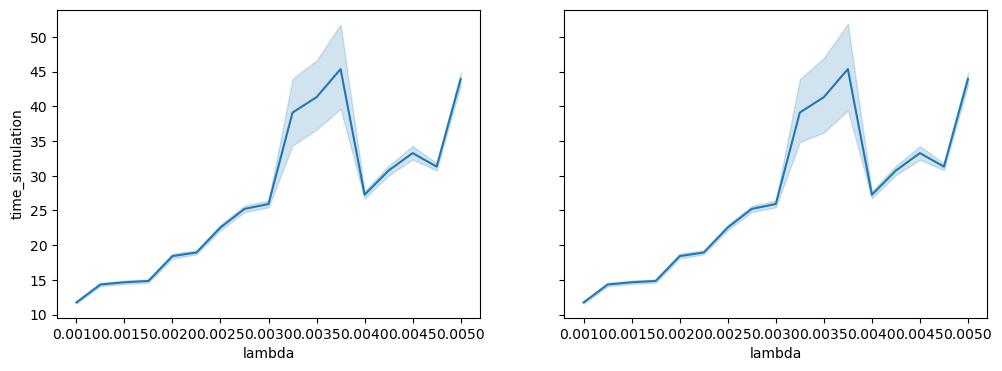

In [11]:
fig_execution_time, axs_execution_time = plt.subplots( 1, 2, sharey=True, figsize=(12,4) )

seaborn.lineplot( data = results,
                  x    = 'lambda',
                  y    = 'time_simulation',
                  ax   = axs_execution_time[0]
                 )

seaborn.lineplot( data = results,
                  x    = 'lambda',
                  y    = 'time_simulation',
                  ax   = axs_execution_time[1]
                 )

We can look the relation between execution time in more detail. Next we consider sampling rate, cutoff, as well as the time it takes to run the simulation and the time it takes to complete clustering analysis.

In [12]:
def plot_t_vs_parameter( data, cutoff, axs, x_parameter_name ):

    # Formatting
    palette = seaborn.color_palette( 'rocket_r' )
    seaborn.set_theme( style='ticks' )
    
    # Filter data
    filtered_data = data[ (data['cutoff']==cutoff) & (data['sampling_rate']>0.2) ]
    filtered_data['execution_time'] = filtered_data['execution_time']/REPS
    
    # total execution time
    seaborn.lineplot( filtered_data, 
                      x   = x_parameter_name, 
                      y   = 'execution_time', 
                      hue = 'sampling_rate',
                      ax  = axs[0], 
                      legend = False,
                      markers = True,
                      palette = palette
                     )
    
    # simulation time
    seaborn.lineplot( filtered_data, 
                      x   = x_parameter_name, 
                      y   = 'time_simulation', 
                      hue = 'sampling_rate', 
                      ax  = axs[1],
                      markers = True,
                      legend = False,
                      err_style = 'bars',
                      palette = palette
                     )

    # Clustering analysis time
    seaborn.lineplot( filtered_data, 
                      x   = x_parameter_name, 
                      y   = 'time_clustering_analysis', 
                      hue = 'sampling_rate', 
                      ax  = axs[2] ,
                      #legend = False,
                      err_style = 'bars',
                      palette = palette
                     )

    # More formatting
    seaborn.despine( ax=axs[0] )
    seaborn.despine( ax=axs[1] )
    seaborn.despine( ax=axs[2] )
    
    axs[1].set_title( 'cutoff = {0}'.format(cutoff) )
    
    axs[0].set_ylabel( 'execution time (s)' )
    axs[1].set_ylabel( 'simulation time (s)' )
    axs[2].set_ylabel( 'clustering analysis time (s)' )

    return

Let's check how the execution time varies depending on `lambda`:

/tmp/ipykernel_11060/1518266109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['execution_time'] = filtered_data['execution_time']/REPS
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/

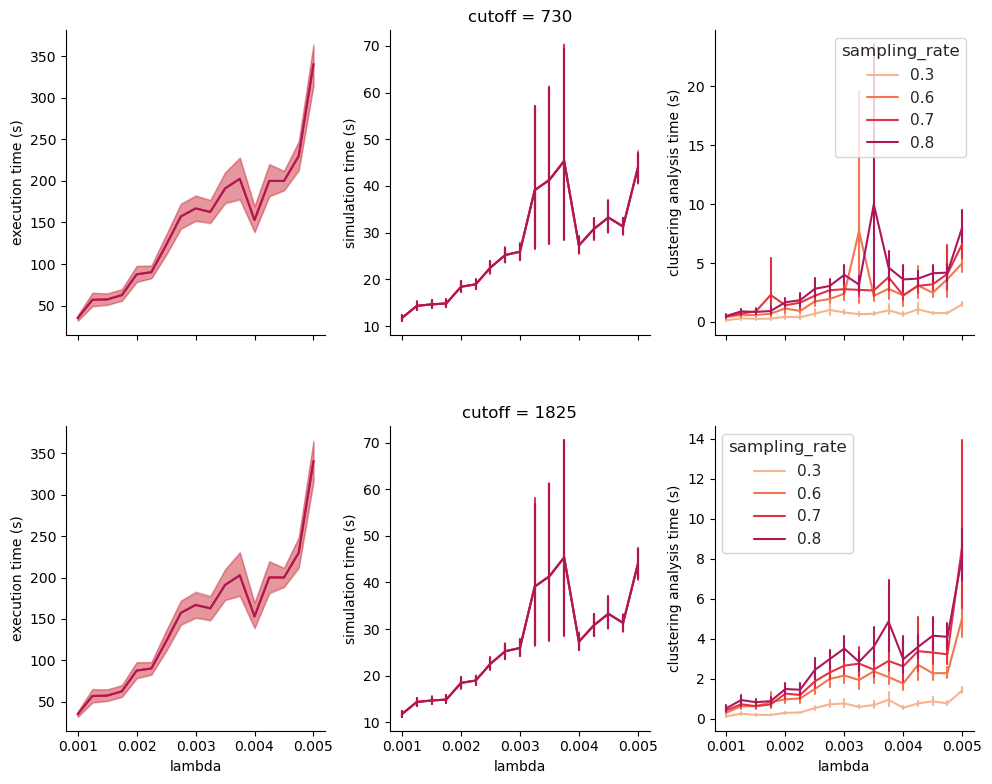

In [13]:
fig_t_vs_samplesize, axs_t_vs_samplesize = plt.subplots( len(CUTOFFS), 3, sharex=True, sharey=False, figsize=(10,8) )

for i, this_cutoff in enumerate( CUTOFFS ):
    plot_t_vs_parameter( results, this_cutoff, axs_t_vs_samplesize[i,:], 'lambda' )
fig_t_vs_samplesize.tight_layout( h_pad=4 )

In [14]:
parameter_names = [ #'samplesize',
                    'mean_partner',
                    #'acts_per_day',
                    'lambda',
                    #'removal_rate',
                    'sampling_delay',
                    #'rand_seed',
                    #'sampling_rate',
                    #'cutoff',
                    #'number_of_leaves_full_tree'
                   ]

columns_to_keep = parameter_names + [ 'reff_mean',  # all after burn-in
                                      #'reff_low',
                                      #'reff_high',
                                      'reff_last_5y_mean',
                                      #'reff_last_5y_low'
                                      #'reff_last_5y_high'
                                      'reff_last_10y_mean',
                                      #'reff_last_10y_low'
                                      #'reff_last_10y_high',
                                      'reff_infections_per_source_mean', 
                                      #'reff_infections_per_source_std',
                                      #'number_of_infections_during_burn_in',
                                      'total_number_of_infections',
                                      'number_of_simulated_days'
                                     ]

solution_space_mean = results.loc[:,columns_to_keep].groupby( parameter_names ).mean().reset_index()

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

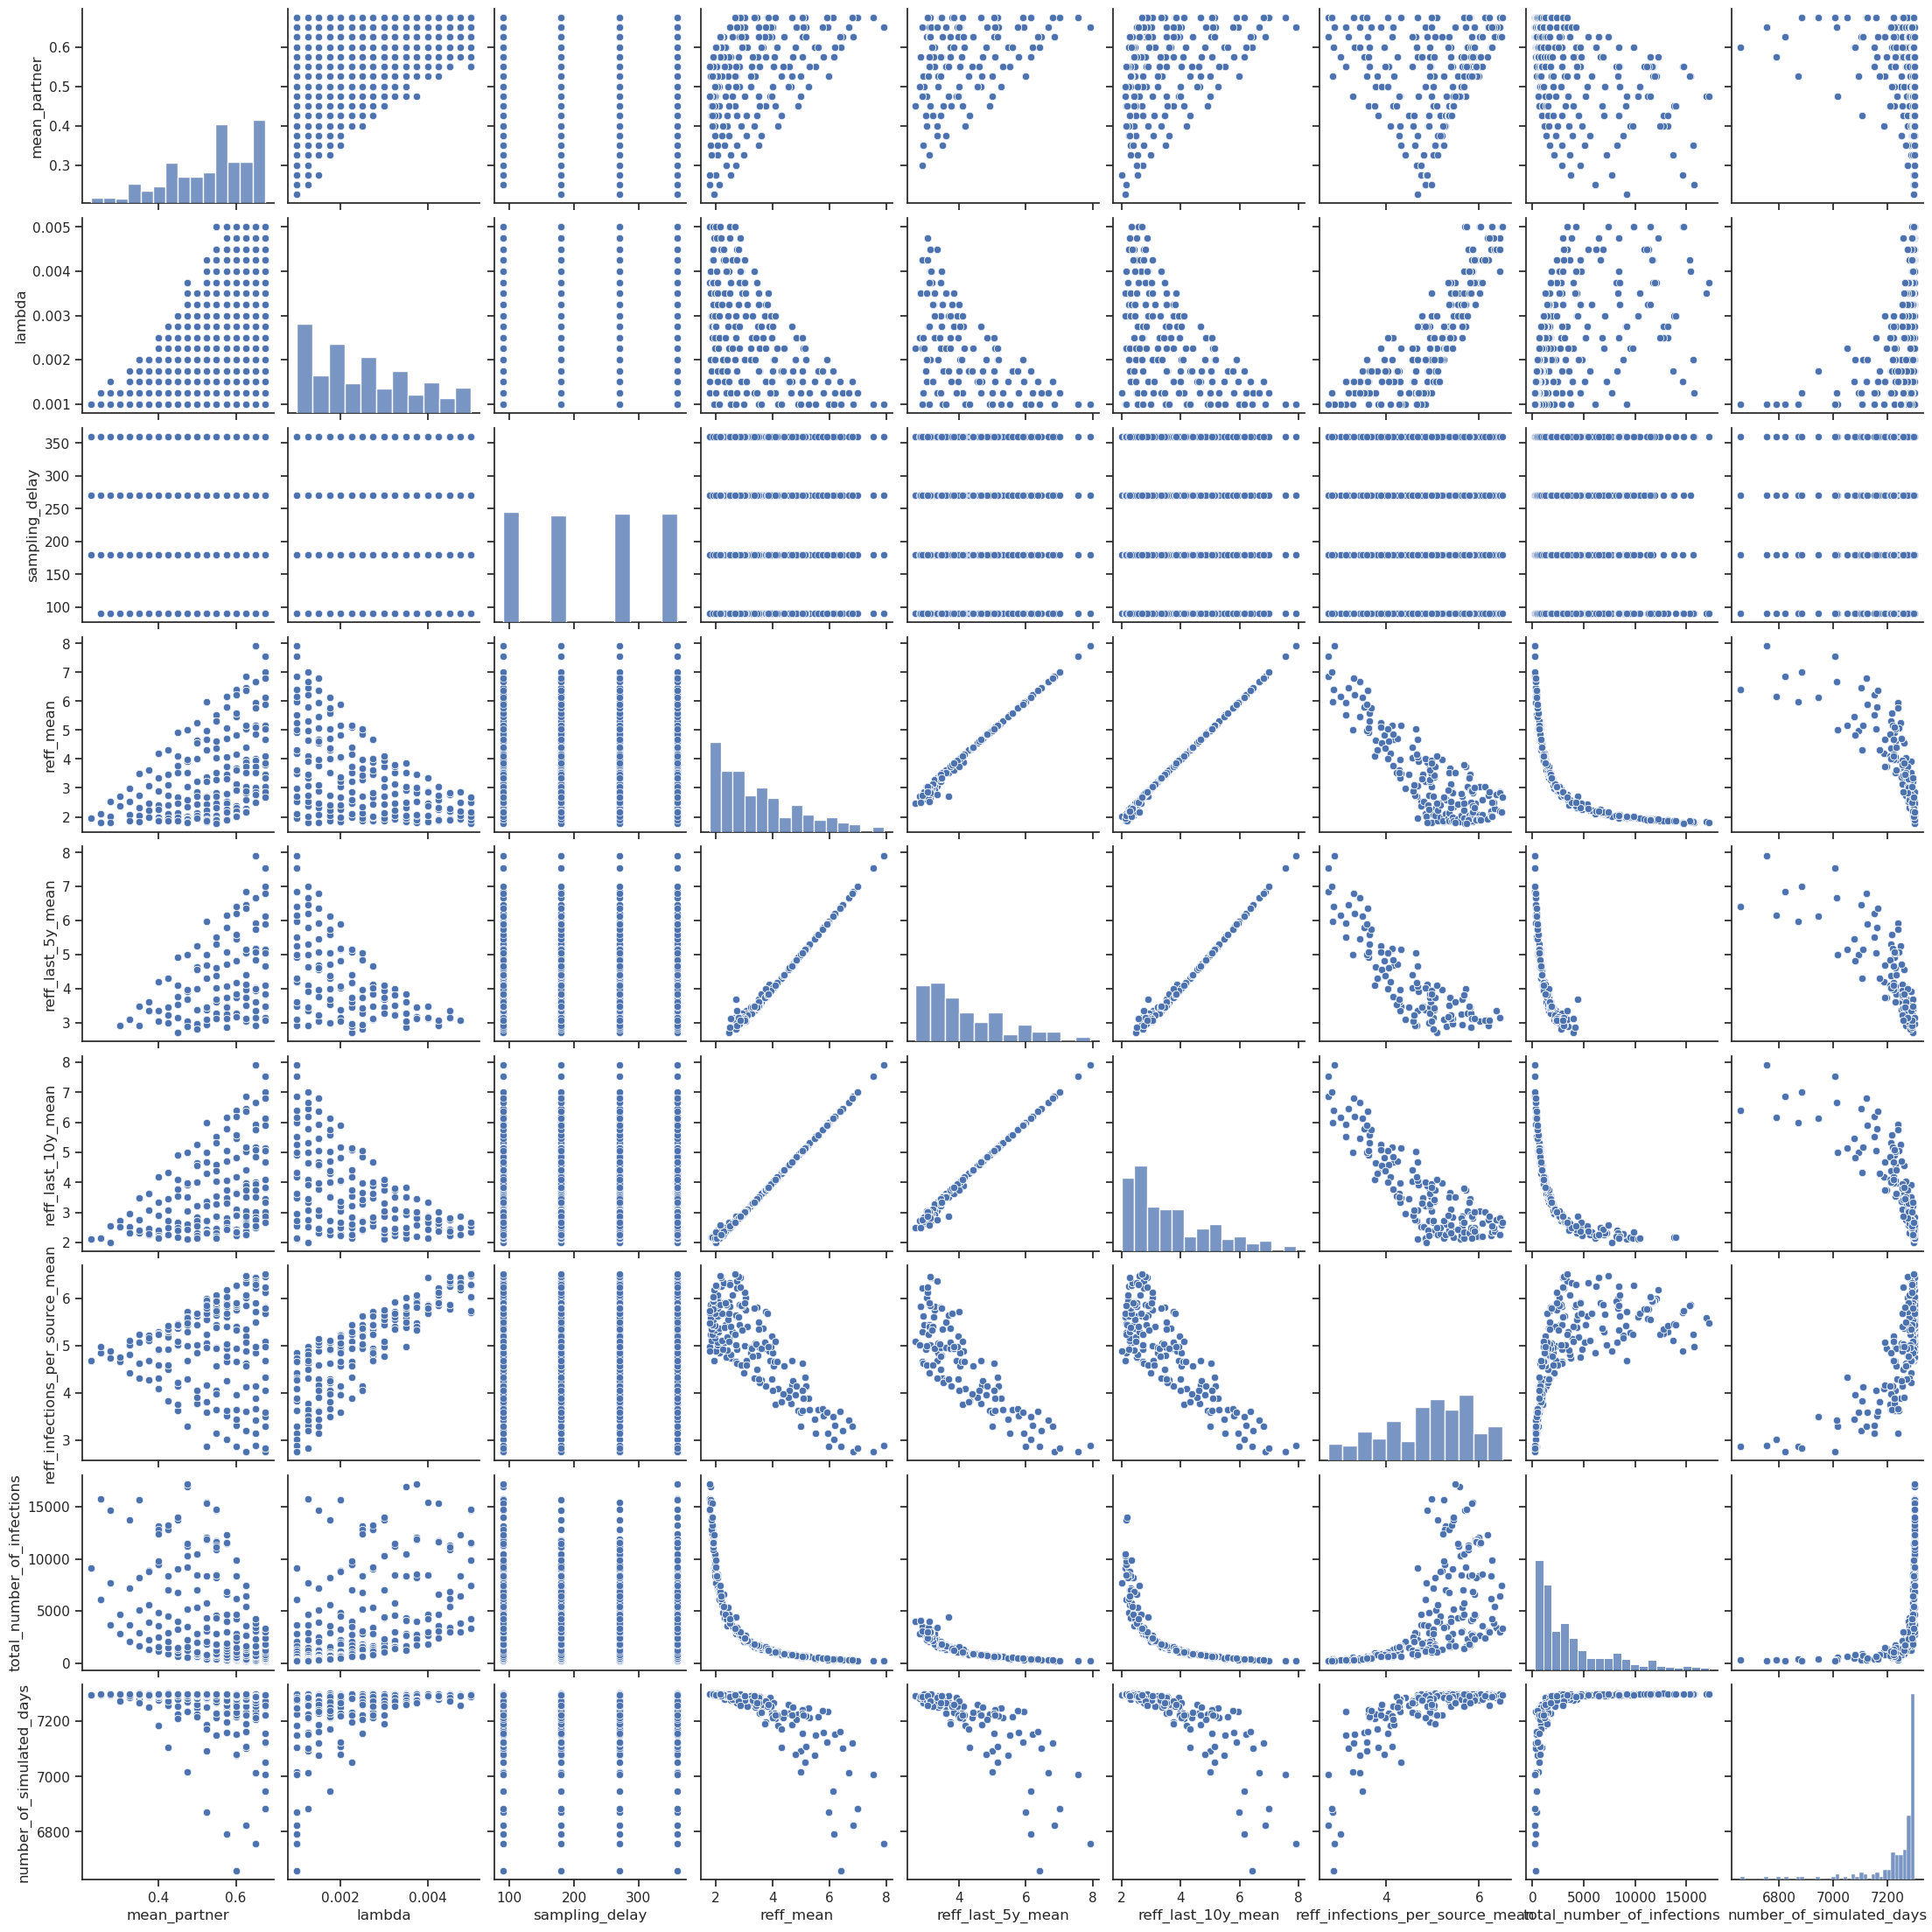

In [15]:
seaborn.pairplot( solution_space_mean )

### Clustering analysis

#### Number of clusters

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

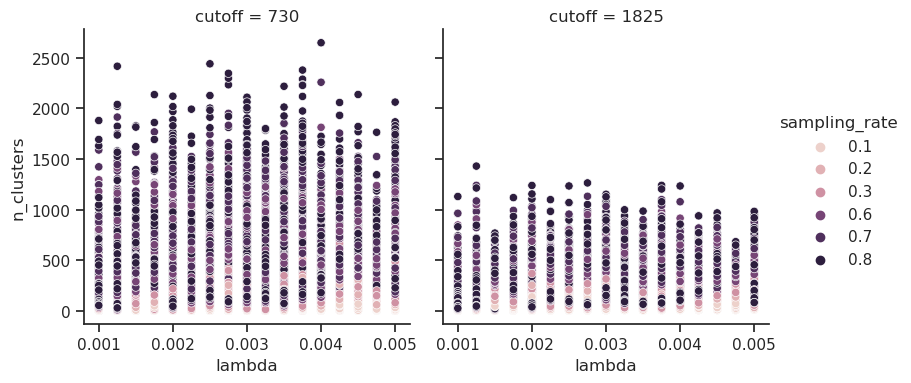

In [16]:
seaborn.relplot( results,
                 x = 'lambda',
                 y = 'n_clusters',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 height = 4
                )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

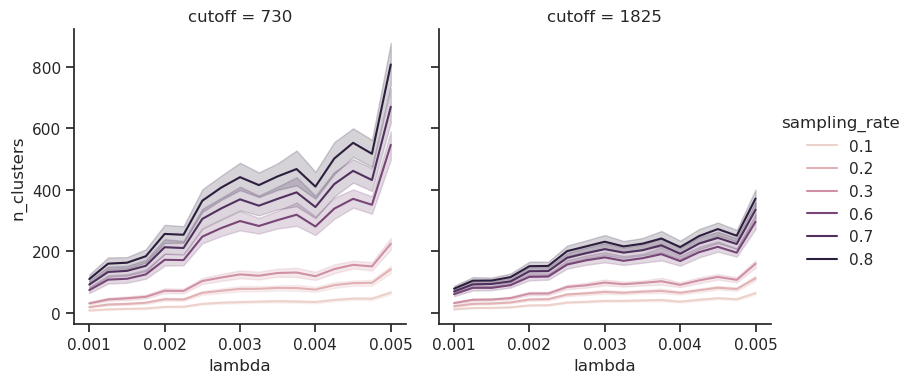

In [17]:
seaborn.relplot( results,
                 x = 'lambda',
                 y = 'n_clusters',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 kind = 'line',
                 height = 4
                )

#### Percentage of samples clustered

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

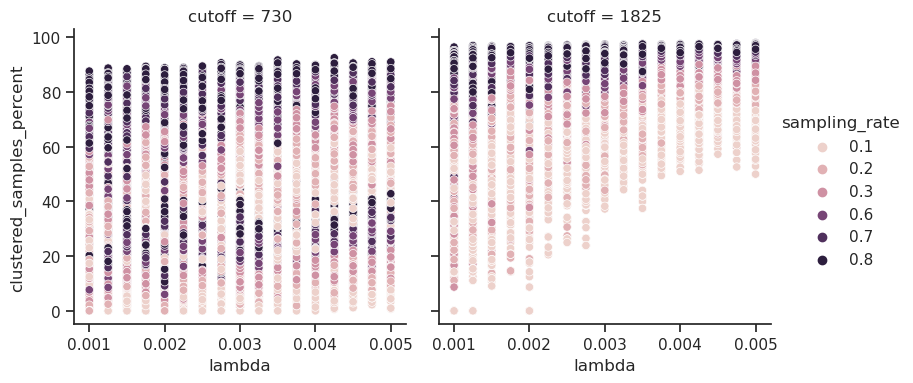

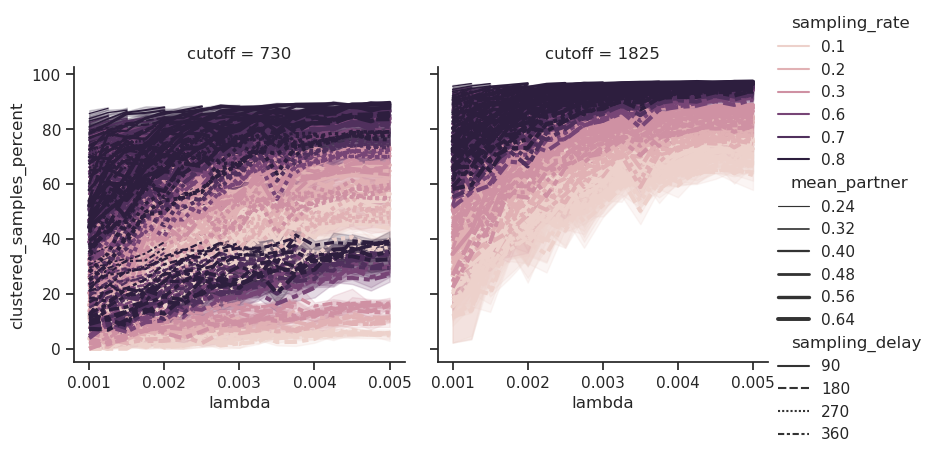

In [18]:
seaborn.relplot( results,
                 x = 'lambda',
                 y = 'clustered_samples_percent',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 height = 4
                )

seaborn.relplot( results,
                 x = 'lambda',
                 y = 'clustered_samples_percent',
                 hue =  'sampling_rate',
                 size = 'mean_partner',
                 col = 'cutoff',
                 kind = 'line',
                 style = 'sampling_delay',
                 height = 4
                )

#### Cluster size (mean)

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

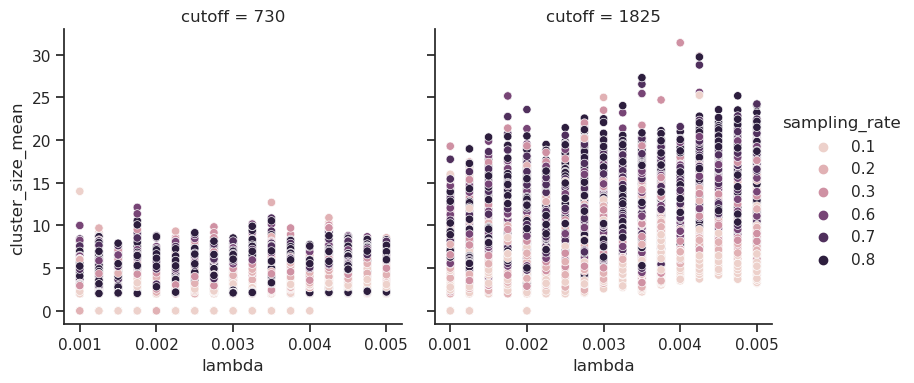

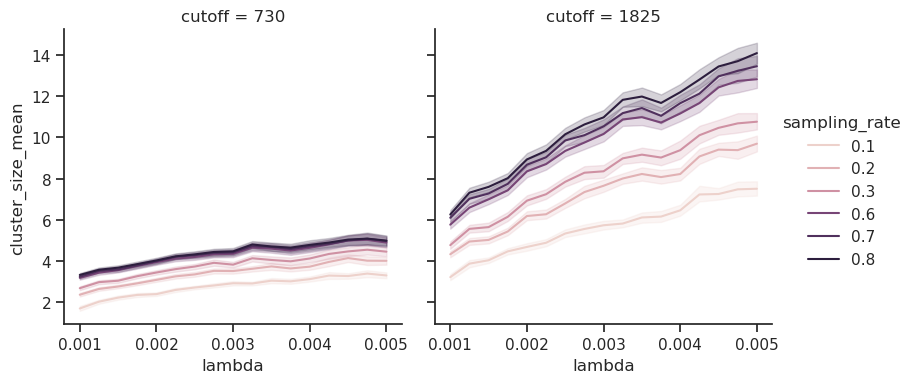

In [19]:
seaborn.relplot( results,
                 x = 'lambda',
                 y = 'cluster_size_mean',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 height = 4
                )

seaborn.relplot( results,
                 x = 'lambda',
                 y = 'cluster_size_mean',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 kind = 'line',
                 height = 4
                )

#### Cluster size (Coefficient of Variation, CoV)

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

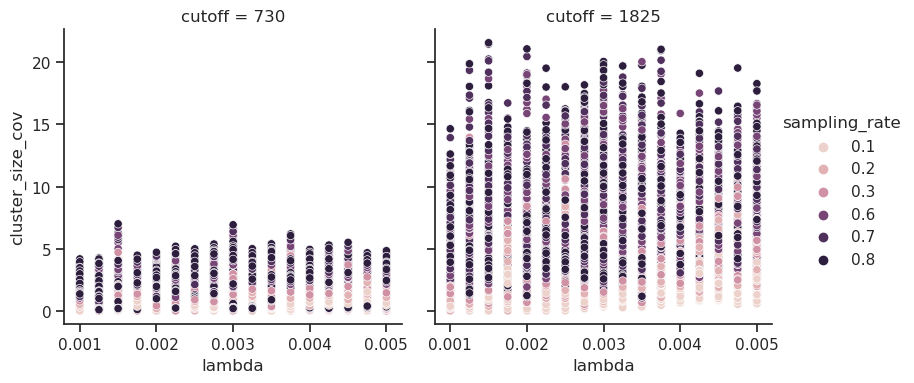

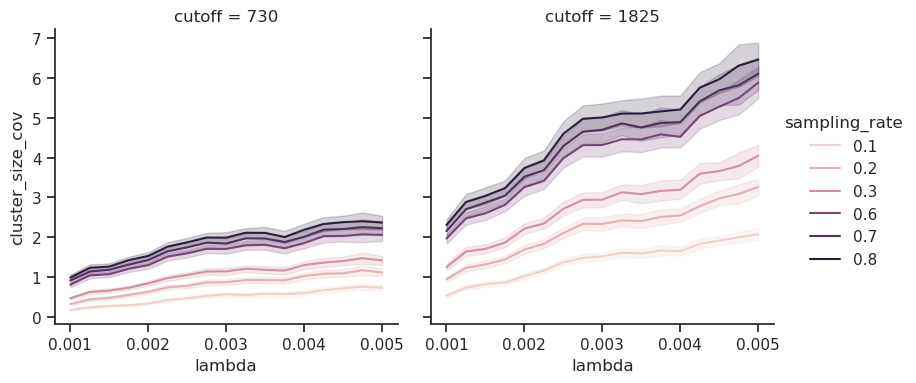

In [20]:
seaborn.relplot( results,
                 x = 'lambda',
                 y = 'cluster_size_cov',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 height = 4
                )

seaborn.relplot( results,
                 x = 'lambda',
                 y = 'cluster_size_cov',
                 hue =  'sampling_rate',
                 col = 'cutoff',
                 kind = 'line',
                 height = 4
                )

#### Other visualizations

In [21]:
def plot_clustering_heatmaps( data, cutoff, axs, parameter_name ):

    # Prepare data
    filtered_data = data[ data['cutoff']==cutoff ]
    filtered_data_means = filtered_data.drop( columns=list( filtered_data.select_dtypes(exclude=[np.number] ).columns ) )   \
                                       .groupby( [parameter_name, 'sampling_rate'] )    \
                                       .mean()

    # % of samples clustered
    seaborn.heatmap( filtered_data_means['clustered_samples_percent'].unstack(),
                     cmap = 'Greens',
                     ax = axs[0],
                   )

    # Cluster size (mean)
    seaborn.heatmap( filtered_data_means['cluster_size_mean'].unstack(),
                     cmap = 'Oranges',
                     ax = axs[1]
                   )

    # Cluster size (CoV)
    seaborn.heatmap( filtered_data_means['cluster_size_cov'].unstack(),
                     cmap = 'Blues',
                     ax = axs[2]
                   )

    # Formatting
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()

    axs[0].set_title( 'clustered samples (%)' )
    axs[1].set_title( 'cutoff = {0}\n\ncluster size (mean)'.format(cutoff) )
    axs[2].set_title( 'cluster size (CoV)' )
    return

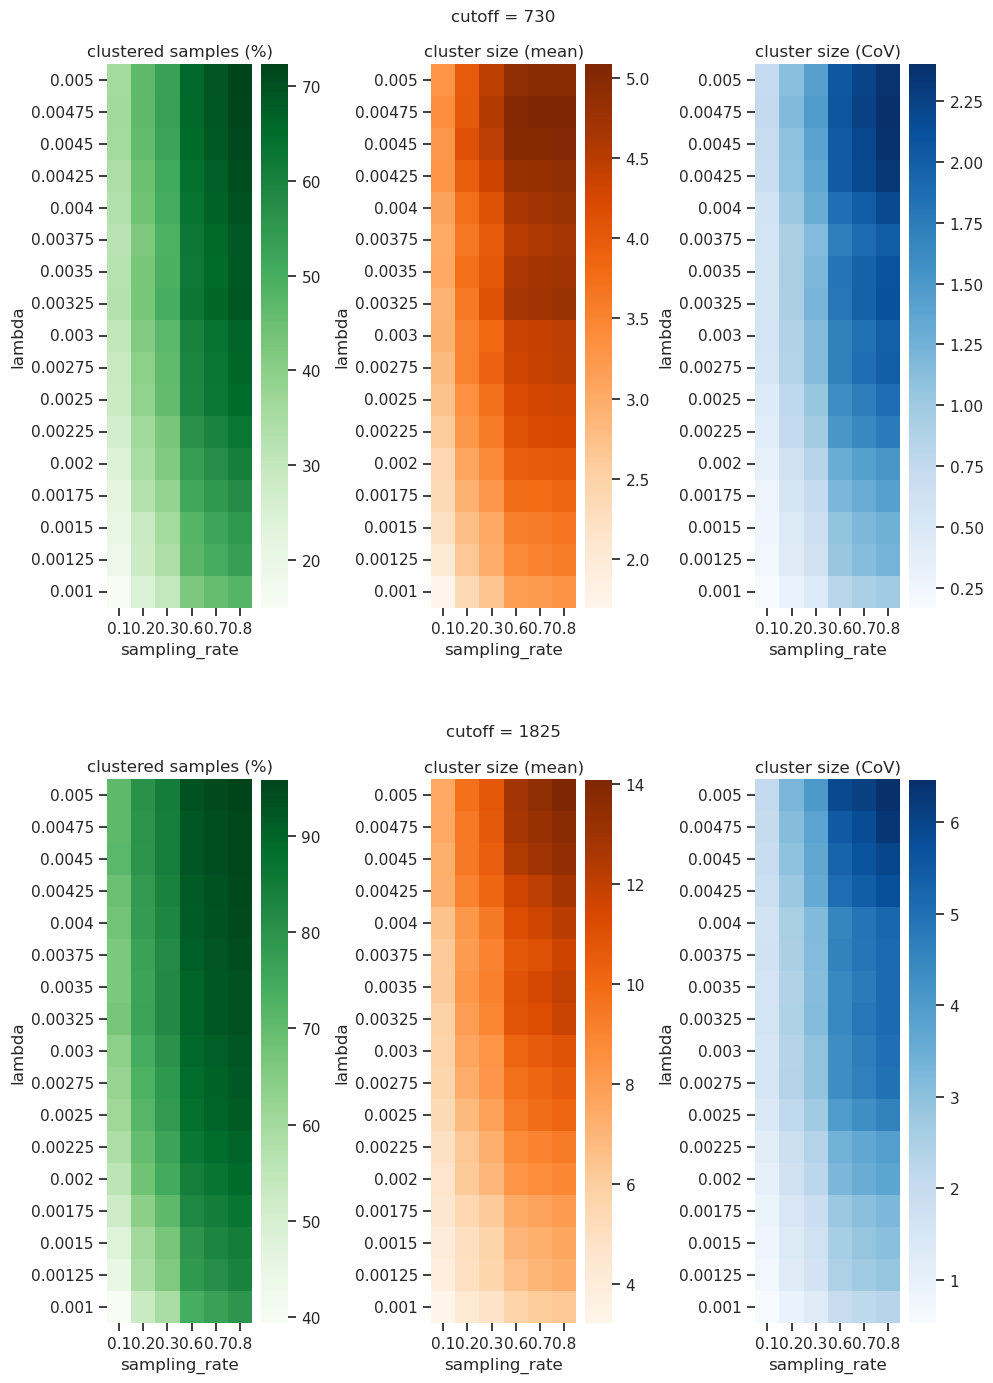

In [22]:
fig_cluster_heat, axs_cluster_heat = plt.subplots( len(CUTOFFS), 3, sharex=False, sharey=False, figsize=(10,14) )

for i, this_cutoff in enumerate( CUTOFFS ):
    plot_clustering_heatmaps( results, this_cutoff, axs_cluster_heat[i,:], 'lambda' )
fig_cluster_heat.tight_layout( h_pad=4 )

In [23]:
def plot_clustering_heatmaps_3d( data, param_x, param_y, param_z, 
                                 param_colormap, 
                                 param_x_label = None, 
                                 param_y_label = None,
                                 param_z_label = None,
                                 param_colormap_label = None,
                                 colormap_name = None,
                                 param_filters={}, 
                                 axs=None ):

    import math
    
    # Prepare data
    filtered_data = data
    for key in param_filters:
        filtered_data = filtered_data[ filtered_data[key]==param_filters[key] ]
    filtered_data = filtered_data.drop( columns=list( filtered_data.select_dtypes(exclude=[np.number] ).columns ) )
    filtered_data = filtered_data.groupby( [param_x, param_y] ).mean()

    # Prepare axes
    column_names = filtered_data[param_z].unique()
    n_columns = len( column_names )
    if axs is None:
        fig, axs = plt.subplots( 1, n_columns, sharex=True, sharey=True, figsize=(12,6) )
    vmin = math.floor( filtered_data[ param_colormap ].min() )
    vmax = math.ceil( filtered_data[ param_colormap ].max() )
    if param_x_label is None:
        param_x_label = param_x
    if param_y_label is None:
        param_y_label = param_y
    if param_z_label is None:
        param_z_label = param_z
    if colormap_name is None:
        colormap_name = 'Reds'

    # Draw heatmaps
    for col, col_name in enumerate(column_names):
        show_colorbar = True   if col==(len(column_names)-1)   else False
        data_to_plot = filtered_data[ filtered_data[param_z]==col_name ]
        
        if param_colormap_label is None:
            param_colormap_label = param_colormap
        
        seaborn.heatmap( data_to_plot[param_colormap].unstack(), 
                         vmin = vmin,
                         vmax = vmax,
                         cmap = colormap_name,
                         cbar = show_colorbar,
                         cbar_kws = { 'label' : param_colormap_label, 'pad':0.1 },
                         ax   = axs[col] 
                        )

        title = '{} = {}'.format( param_z_label, col_name )
        axs[col].set_title( title )
        axs[col].set_xlabel( param_x_label )
        axs[col].set_ylabel( param_y_label )
        axs[col].invert_yaxis()

    # Format figure
    fig.tight_layout( w_pad=3 )    
    return

/tmp/ipykernel_11060/2792301463.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout( w_pad=3 )


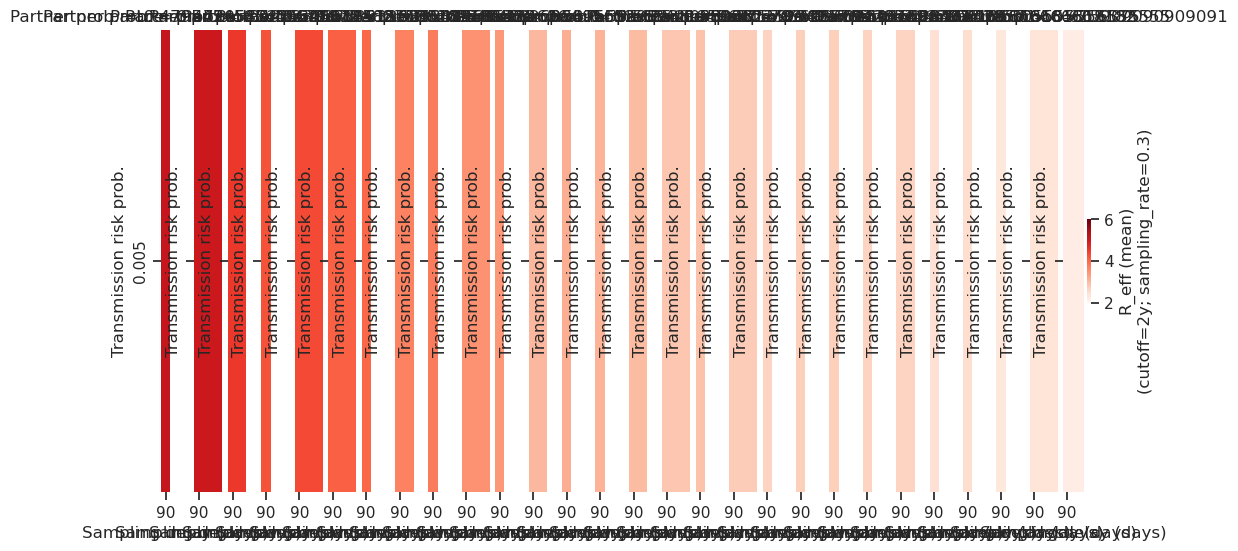

In [24]:
filters = {}
filters['cutoff'] = 730
filters['sampling_rate'] = 0.3
plot_clustering_heatmaps_3d( results, 
                             'lambda',
                             'sampling_delay', 
                             'mean_partner',
                             'reff_mean',
                             'Sampling delay (days)',
                             'Transmission risk prob.',                            
                             'Partner prob.',
                             'R_eff (mean)\n(cutoff=2y; sampling_rate=0.3)',
                             param_filters = filters 
                            )

/tmp/ipykernel_11060/2792301463.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout( w_pad=3 )
/tmp/ipykernel_11060/2792301463.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout( w_pad=3 )
/tmp/ipykernel_11060/2792301463.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout( w_pad=3 )


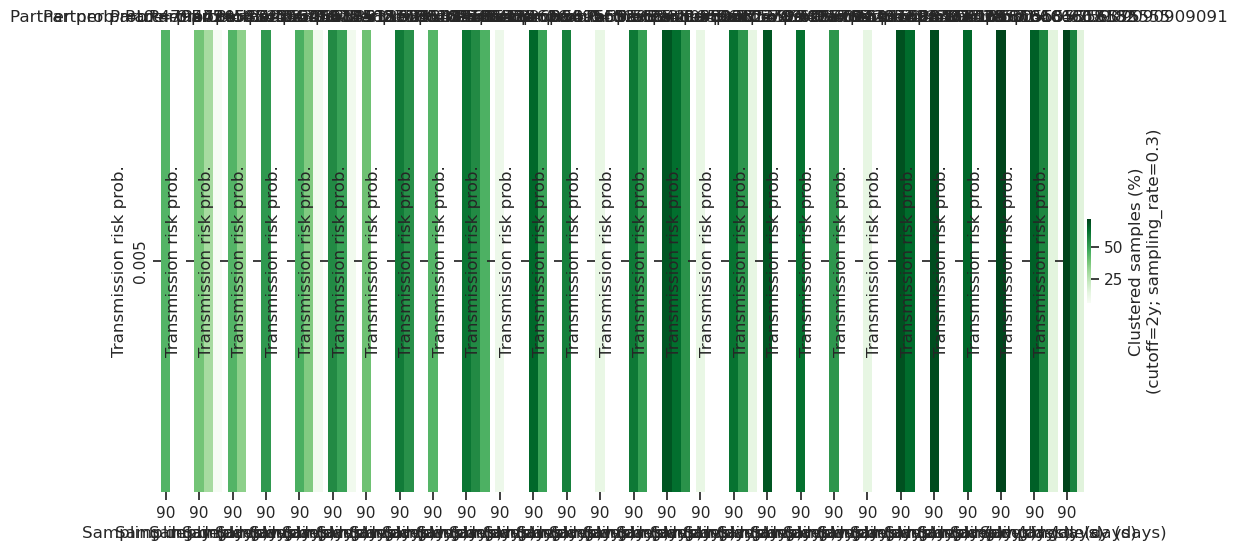

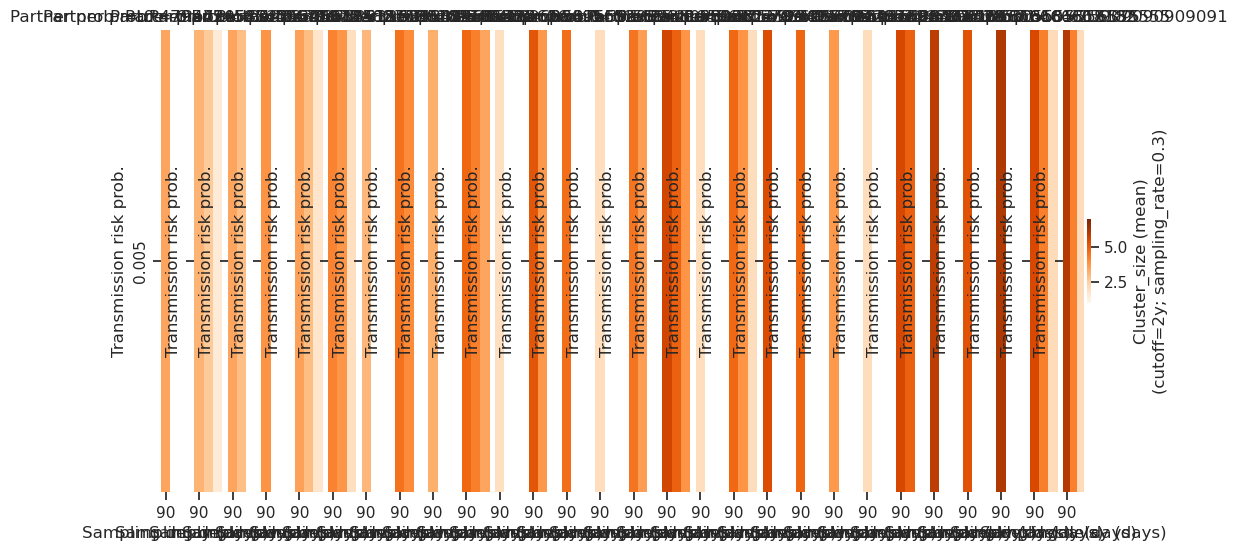

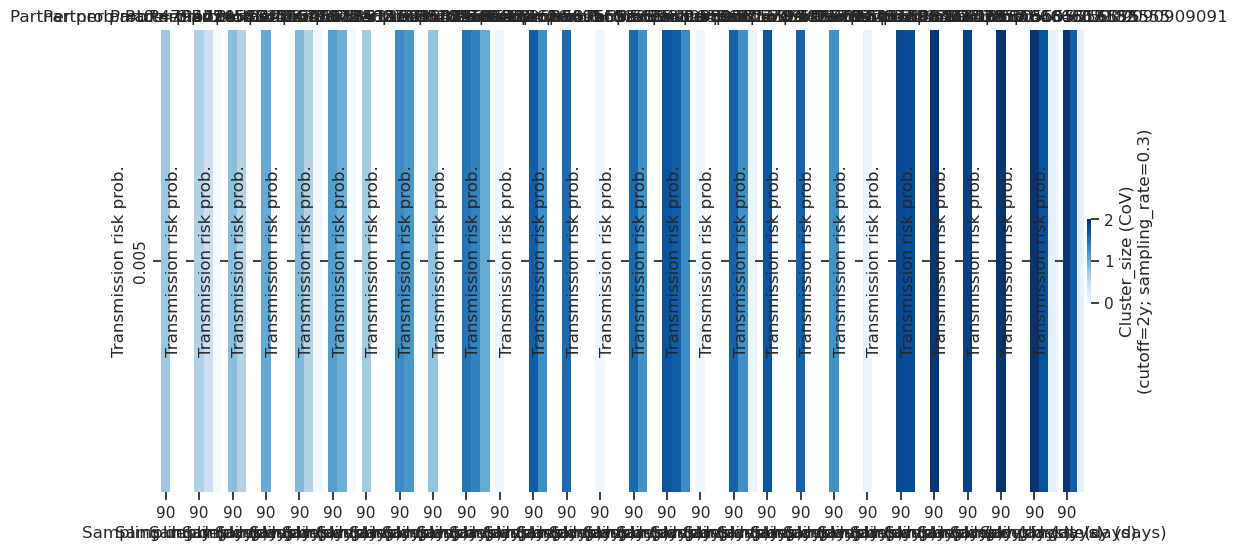

In [25]:
filters = {}
filters['cutoff'] = 730
filters['sampling_rate'] = 0.3

plot_clustering_heatmaps_3d( results, 
                             'lambda',
                             'sampling_delay', 
                             'mean_partner',
                             'clustered_samples_percent',
                             'Sampling delay (days)',
                             'Transmission risk prob.',                            
                             'Partner prob.',
                             'Clustered samples (%)\n(cutoff=2y; sampling_rate=0.3)',
                             'Greens',
                             param_filters = filters 
                            )

plot_clustering_heatmaps_3d( results, 
                             'lambda',
                             'sampling_delay', 
                             'mean_partner',
                             'cluster_size_mean',
                             'Sampling delay (days)',
                             'Transmission risk prob.',                            
                             'Partner prob.',
                             'Cluster_size (mean)\n(cutoff=2y; sampling_rate=0.3)',
                             'Oranges',
                             param_filters = filters 
                            )

plot_clustering_heatmaps_3d( results, 
                             'lambda',
                             'sampling_delay', 
                             'mean_partner',
                             'cluster_size_cov',
                             'Sampling delay (days)',
                             'Transmission risk prob.',                            
                             'Partner prob.',
                             'Cluster_size (CoV)\n(cutoff=2y; sampling_rate=0.3)',
                             'Blues',
                             param_filters = filters 
                            )

In [58]:
low = 1.0 #0.9
high = 1.0 # 1.1

sampling_coverage = { 'Southern Africa' : [ 0.10, 0.30 ],
                      'Global North'    : [ 0.55, 0.70 ]
                     }
#r_eff = { 'Southern Africa' : [ 0.8*low, 2.0*high ],#2.0*high ],   #5
#          'Global North'    : [ 0.8*low, 2.0*high ]
#         }
r_eff = { 'Southern Africa' : [ 0.8*low, 1.5*high ],#2.0*high ],   #5
          'Global North'    : [ 0.8*low, 1.5*high ]
         }

cluster_size_mean  = { 'Southern Africa' : [ 1.8*low, 2.6*high ],
                       'Global North'    : [ 3.2*low, 5.5*high ]
                      }

cluster_size_cov  = { 'Southern Africa' : [  0.12*low,  1.00*high ],
                      'Global North'    : [   3.0*low, 18.00*high ]   # 10.8
                     }

In [59]:
results['match'] = 'none'
results['Southern Africa'] = np.nan
results['Global North'] = np.nan



# Southern Africa
results.loc[  ( results['sampling_rate'] >= sampling_coverage['Southern Africa'][0] )    \
         &( results['sampling_rate'] <= sampling_coverage['Southern Africa'][1] )    \
         &( results['reff_high'] >= r_eff['Southern Africa'][0] )    \
         &( results['reff_low'] <= r_eff['Southern Africa'][1] )    \
         &( results['cluster_size_mean'] >= cluster_size_mean['Southern Africa'][0] )    \
         &( results['cluster_size_mean'] <= cluster_size_mean['Southern Africa'][1] )    \
         &( results['cluster_size_cov'] >= cluster_size_cov['Southern Africa'][0] )    \
         &( results['cluster_size_cov'] <= cluster_size_cov['Southern Africa'][1] )    \
       ,'Southern Africa'] = True

results.loc[  ( results['sampling_rate'] >= sampling_coverage['Global North'][0] )    \
         &( results['sampling_rate'] <= sampling_coverage['Global North'][1] )    \
         &( results['reff_high'] >= r_eff['Global North'][0] )    \
         &( results['reff_low'] <= r_eff['Global North'][1] )    \
         &( results['cluster_size_mean'] >= cluster_size_mean['Global North'][0] )    \
         &( results['cluster_size_mean'] <= cluster_size_mean['Global North'][1] )    \
         &( results['cluster_size_cov'] >= cluster_size_cov['Global North'][0] )    \
         &( results['cluster_size_cov'] <= cluster_size_cov['Global North'][1] )    \
       ,'Global North'] = True

/tmp/ipykernel_11060/2061115956.py:8: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_11060/2061115956.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [60]:
print( ' results Africa = ', len(results[ results['Southern Africa']==True ]) )
print( ' results North  = ', len(results[ results['Global North']==True ]) )

 results Africa =  1059
 results North  =  427


In [61]:
solutions = results[ (results['Southern Africa']==True) | (results['Global North']==True) ]

solutions_by_match = pd.DataFrame()

count = 0
count_africa = 0
count_north = 0
for index,row in solutions.iterrows():


    if row['Southern Africa'] == True:
        region = 'Southern Africa'
        count_africa += 1
    else:
        region = 'Global North'
        count_north += 1

    this_record = pd.DataFrame( { 'region': region,
                                  'cutoff': row['cutoff'],
                                  'parameter' : [ 'Sampling fraction', 
                                                  'mean_partner', 
                                                  'acts_per_day', 
                                                  'Mean risk of infection', 
                                                  'removal_rate', 
                                                  'Sampling delay (days)',
                                                  'Mean number of partners'
                                                 ],
                                  'value' : [ row['sampling_rate'], 
                                              row['mean_partner'], 
                                              row['acts_per_day'], 
                                              row['lambda'], 
                                              row['removal_rate'], 
                                              row['sampling_delay'],
                                              1/row['mean_partner'] 
                                             ],
                                 }
                              )
    solutions_by_match = pd.concat( [solutions_by_match, this_record], ignore_index=True )
    

print( '... found ', count_africa, ' matches for Southern Africa and ', count_north, ' matches for the Global North.' )

... found  1059  matches for Southern Africa and  427  matches for the Global North.


/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

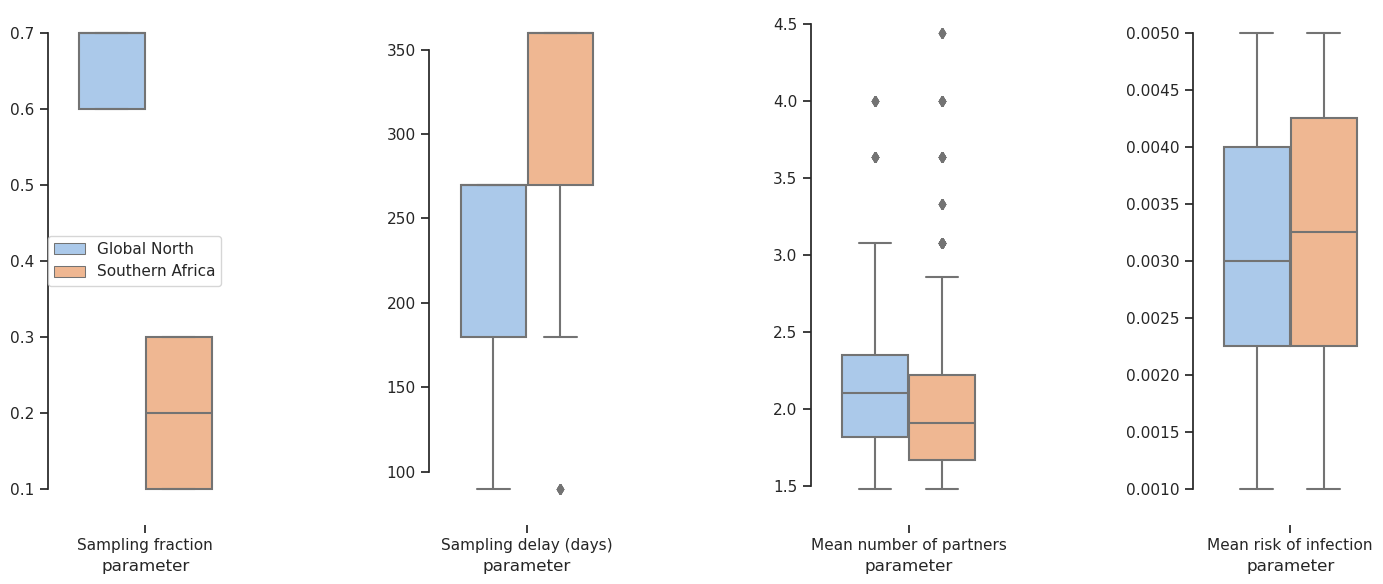

In [62]:
fig_param_space, axs_param_space = plt.subplots(1, 4, figsize=(14,6) )


def compare_params( solution_space, parameter_name, cutoff_value, ax, show_legend=False ):

    seaborn.set_theme(style="ticks", palette="pastel")
    
    solutions_filtered = solution_space[ solution_space['parameter']==parameter_name ]
    
    #seaborn.boxplot( data = solutions_filtered, 
    #                 x    = 'parameter', 
    ##                 y    = 'value',
     #                hue  = 'region',
     #                ax   = ax
     #               )
    #seaborn.violinplot( data = solutions_filtered, 
    seaborn.boxplot( data = solutions_filtered, 
                     x    = 'parameter', 
                     y    = 'value',
                     hue  = 'region',
                     ax   = ax,
                     #inner = 'quart', bw_method = 'silverman', density_norm = 'area'
                    )

    seaborn.despine( offset=10, trim=True, ax=ax )

    ax.set_ylabel('')

    if not show_legend:
        ax.legend().set_visible(False)
    else:
        ax.legend( loc='right' )
        #ax.legend( bbox_to_anchor=(1.01, 1), loc='upper left' )#, borderaxespad=0 )
    
    return


parameters_to_show = [ 'Sampling fraction', #'sampling_rate', 
                       'Sampling delay (days)', #'sampling_delay',
                       'Mean number of partners', #'mean_partner',
                       #'acts_per_day',
                       'Mean risk of infection', #'lambda',
                       #'removal_rate'
                       
                      ]                           

for i, parameter_name in enumerate( parameters_to_show ):
    show_legend = True if i==0 else False
    compare_params( solutions_by_match, parameter_name, 730, axs_param_space[i], show_legend )


# Some formatting
fig_param_space.tight_layout( w_pad = 8 )


In [ ]:
#solutions = results[ (results['Southern Africa']==True) | (results['Global North']==True) ]

In [63]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

# Scenario of interest
#relevant_results = solutions[ (solutions['cutoff']==730) & (solutions['Southern Africa']==True) ]
relevant_results = solutions[ (solutions['cutoff']==730) & (solutions['Global North']==True) ]

# Draw the plot
fig = px.parallel_coordinates( relevant_results, 
                               color = 'Southern Africa', 
                               dimensions = [ 'sampling_rate', 
                                              'sampling_delay',
                                              'lambda',
                                              'mean_partner',
                                             ],
                               color_continuous_scale = px.colors.sequential.BuGn_r,
                              # range_color=[0, threshold],
                              #color_continuous_midpoint=0.5
                              )
fig.show()

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

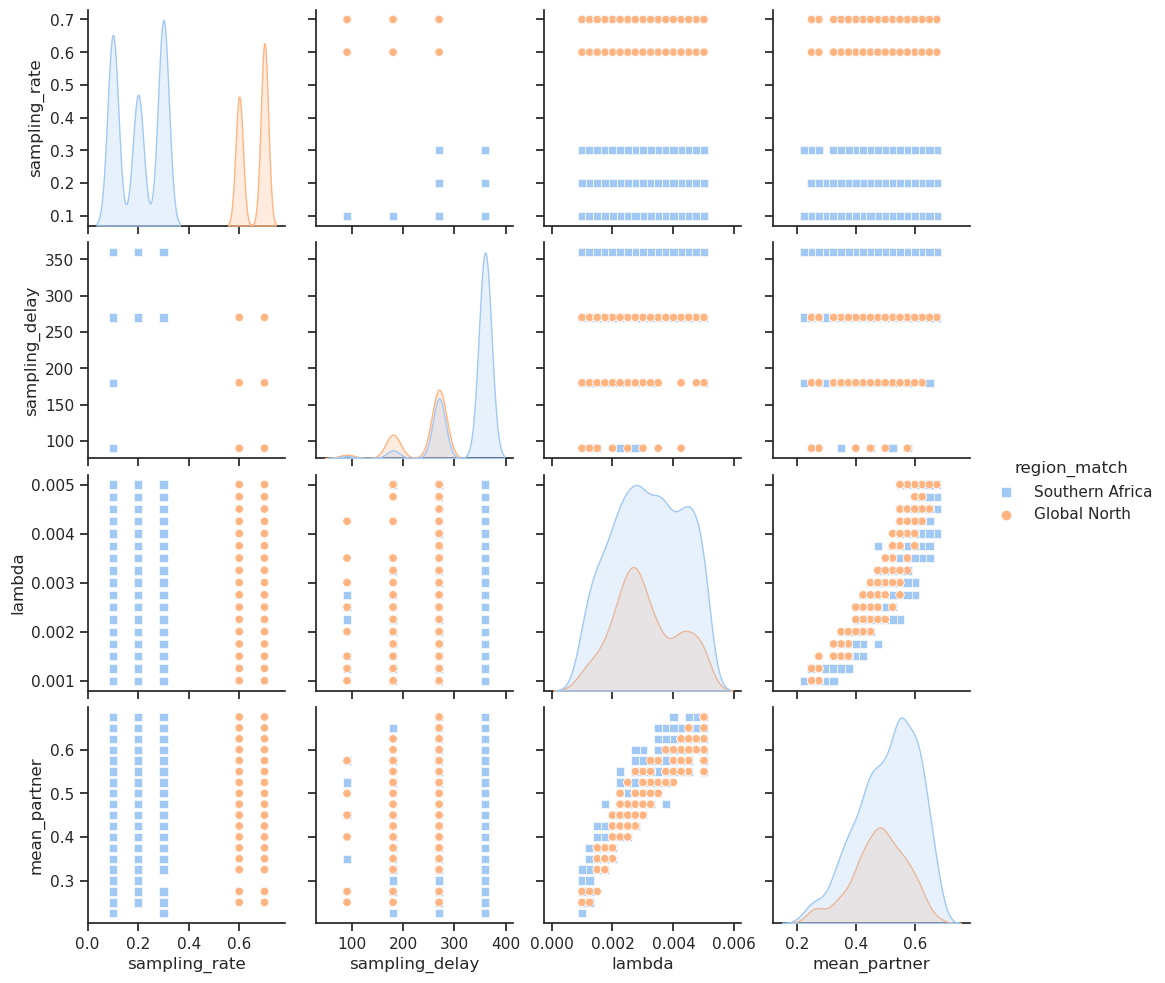

In [64]:
#solution_space = pd.DataFrame()

columns = [ 'sampling_rate', 
            'sampling_delay',
            'lambda',
            'mean_partner',
            'Southern Africa',
            'Global North'
          ]

solution_space_Africa = solutions[ (solutions['cutoff']==730) & (solutions['Southern Africa']==True) ].loc[:,columns]
solution_space_North  = solutions[ (solutions['cutoff']==730) & (solutions['Global North'   ]==True) ].loc[:,columns]

solution_space_Africa['region_match'] = 'Southern Africa'
solution_space_North ['region_match'] = 'Global North'

#solution_space_Africa.head()
#solution_space_North.head()

solution_space = pd.concat( [ solution_space_Africa, solution_space_North ], ignore_index=True )    \
                   .drop( columns=['Southern Africa', 'Global North'] )
solution_space.head()

seaborn.pairplot( solution_space, 
                  hue='region_match', 
                  markers=['s', 'o'], 
                  #kind='hist' 
                 )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

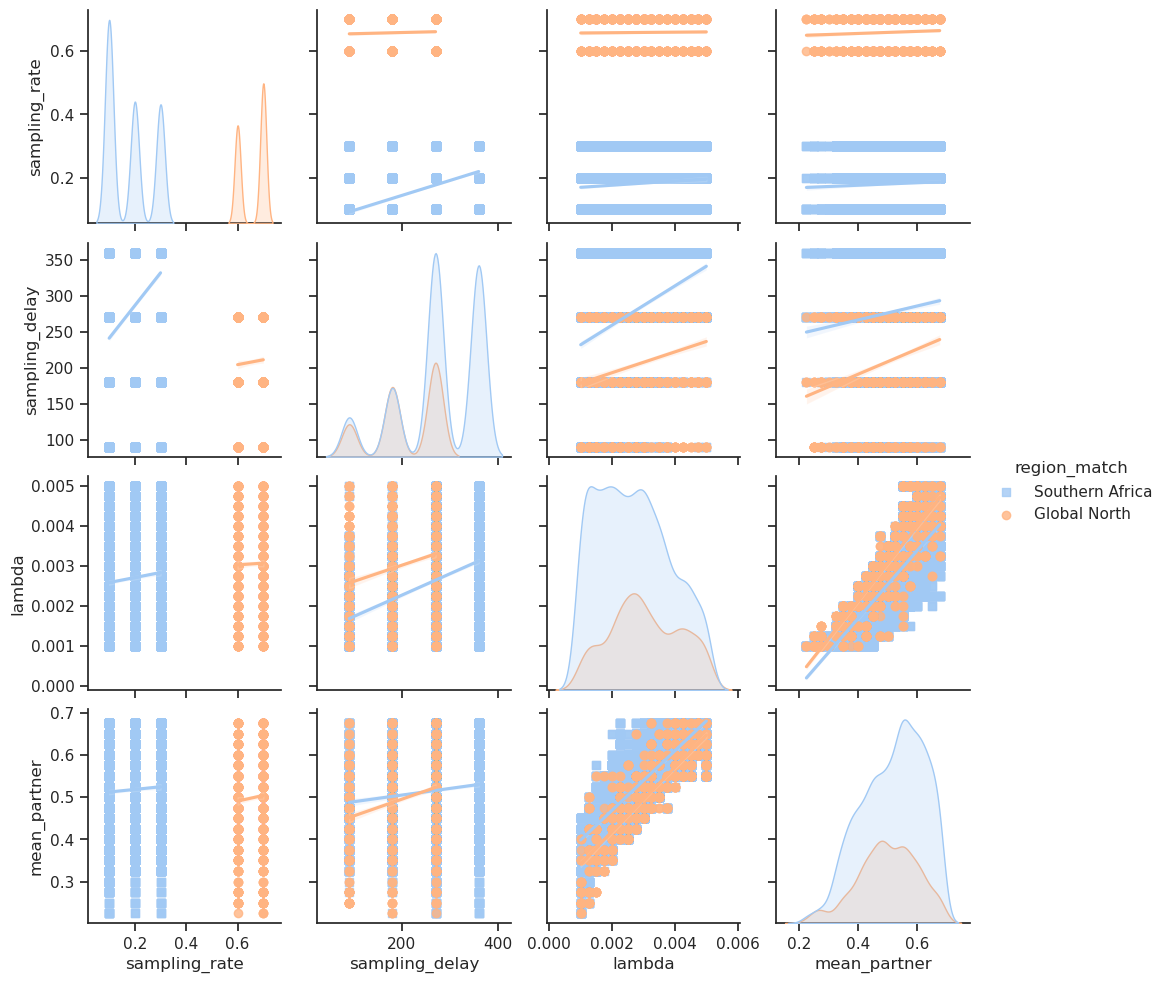

In [41]:
seaborn.pairplot( solution_space, 
                  hue='region_match', 
                  markers=['s', 'o'], 
                  kind='reg' 
                 )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

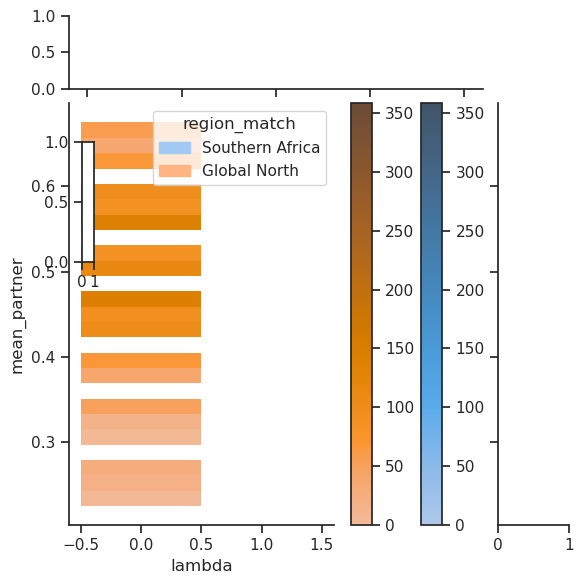

In [47]:
g = seaborn.JointGrid( data = solution_space, 
                       x = 'lambda', 
                       y = 'mean_partner', 
                       hue = 'region_match',
                       marginal_ticks = True
                      )
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint( seaborn.histplot, discrete=(True, False),
              pmax=.8, 
              cbar=True, 
              #cbar_ax=cax
             )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

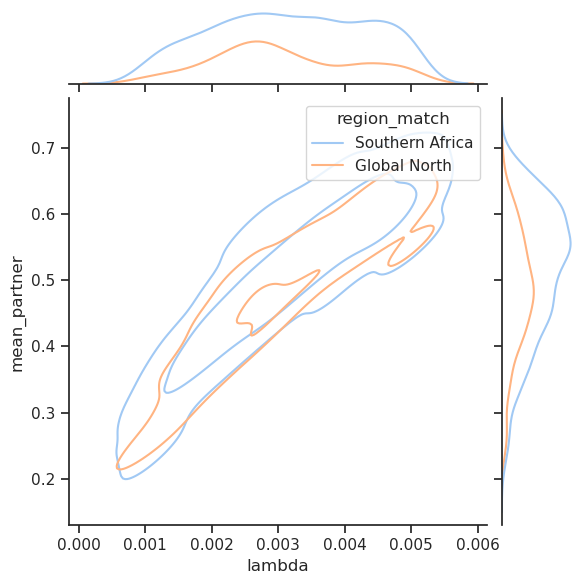

In [71]:
seaborn.jointplot( data=solution_space, 
                   x = 'lambda', 
                   y = 'mean_partner',
                   hue = 'region_match',
                   #kind = 'hist',
                   #kind = 'hex',
                   kind = 'kde',levels=3
                   #kind = 'reg'
                  )


/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

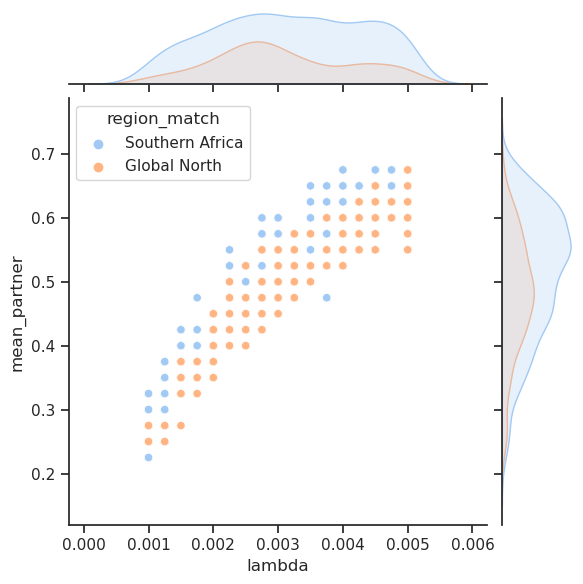

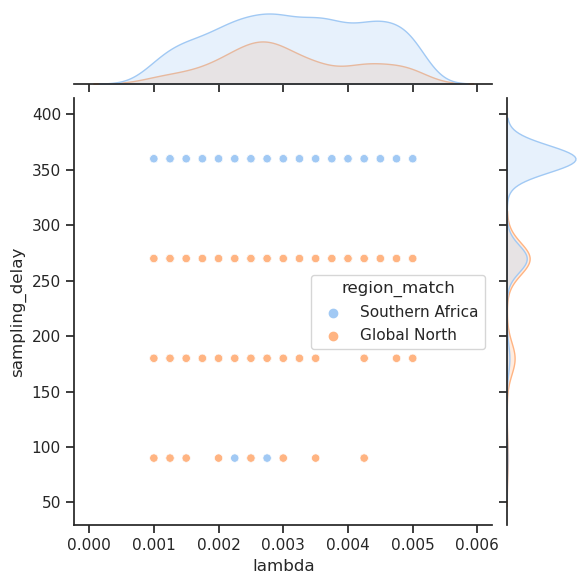

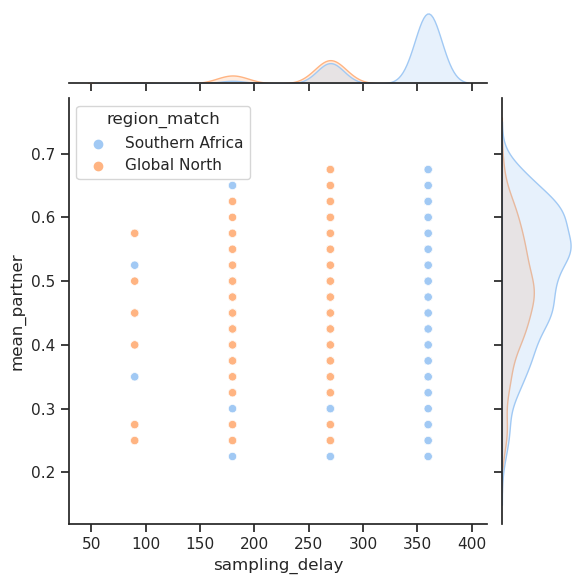

In [74]:
seaborn.jointplot( data=solution_space, 
                   x = 'lambda', 
                   y = 'mean_partner',
                   hue = 'region_match',
                  )
seaborn.jointplot( data=solution_space, 
                   x = 'lambda', 
                   y = 'sampling_delay',
                   hue = 'region_match',
                  )
seaborn.jointplot( data=solution_space, 
                   x = 'sampling_delay', 
                   y = 'mean_partner',
                   hue = 'region_match',
                  )

In [75]:
solution_space_new_names = solution_space.rename( columns = { 'sampling_rate'  : 'Sampling fraction', 
                                                              'sampling_delay' : 'Sampling delay (days)',
                                                              'lambda'         : 'Mean risk of infection',
                                                              'region_match'   : 'Region'
                                                             }
                                                 )
solution_space_new_names['Mean number of partners'] = 1/solution_space_new_names['mean_partner']

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

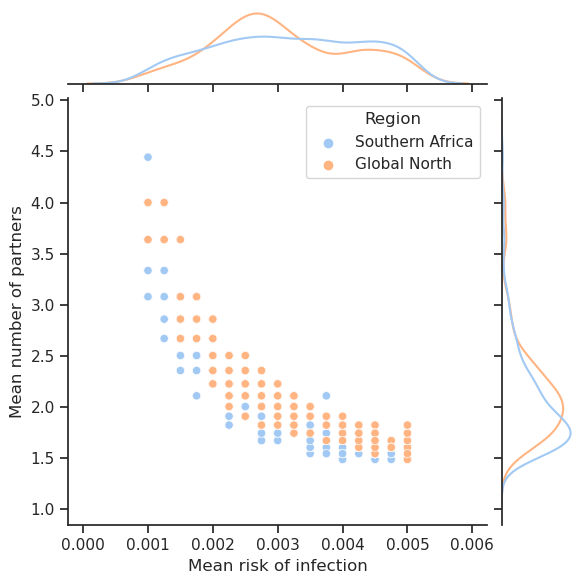

In [99]:
seaborn.jointplot( data = solution_space_new_names,
                   x    = 'Mean risk of infection',
                   y    = 'Mean number of partners',
                   hue  = 'Region',
                   marginal_kws = { 'multiple': 'layer',
                                    'common_norm' : False,
                                    #'cumulative' : True,
                                    #'common_grid' : True,
                                    'fill' : False
                                   }
                  )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

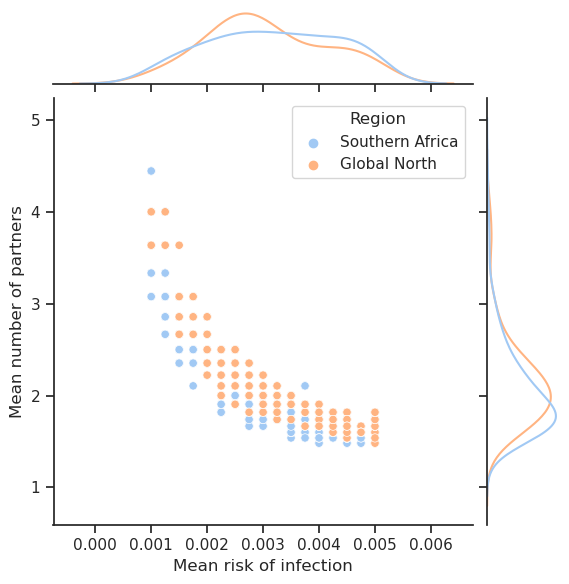

In [129]:
seaborn.jointplot( data = solution_space_new_names,
                   x    = 'Mean risk of infection',
                   y    = 'Mean number of partners',
                   hue  = 'Region',
                   marginal_kws = { 'multiple': 'layer',
                                    'common_norm' : False,
                                    #'cumulative' : True,
                                    #'common_grid' : True,
                                    'fill' : False,
                                    'bw_adjust' : 1.5
                                   }
                  )

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/clustersim_20230720/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/rnunez/anaconda3/envs/

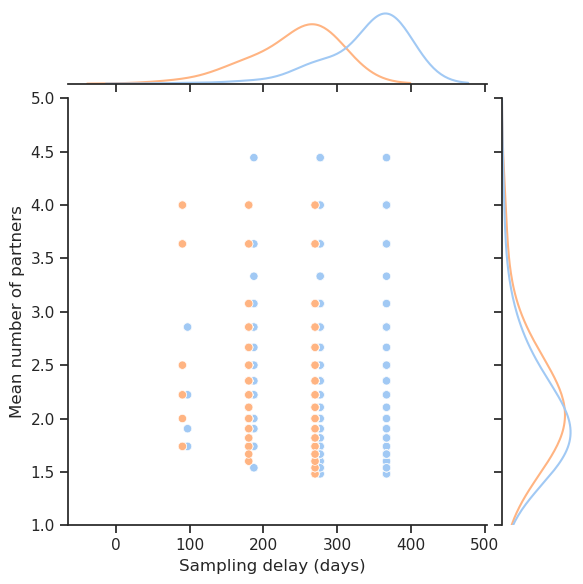

In [131]:
solution_space_new_names['Sampling delay (days)  '] = solution_space_new_names['Sampling delay (days)']
solution_space_new_names.loc[ solution_space_new_names['Region']=='Southern Africa', 'Sampling delay (days)  '] = \
    solution_space_new_names.loc[ solution_space_new_names['Region']=='Southern Africa', 'Sampling delay (days)'] + 7

seaborn.jointplot( data = solution_space_new_names,
                   x    = 'Sampling delay (days)  ',
                   y    = 'Mean number of partners',
                   hue  = 'Region',
                   ylim = [1.0, 5.0],
                   legend = False,
                   marginal_kws = { 'multiple': 'layer',
                                    'common_norm' : False,
                                    #'cumulative' : True,
                                    #'common_grid' : True,
                                    'fill' : False,
                                    'bw_adjust' : 3.0
                                   }
                  )